# Image classification of six-sided dice
### Using Keras and a LeNet-5 inspired Convolutional Neural Network

This part of the project made use of Mario Lurig's dice image dataset, linked at the bottom of this cell. In this project, I focus on only six-sided dice, but the dataset includes many different kinds of dice (d4, d8, d12, etc.).

The dice image dataset (as published on kaggle) was unlabled. However, the ordering of the images made it relatively quick to label - there are 100-200 images in a row of the same die (from different angles). I was able to label groups of images in bulk, using an open excel sheet to extend the same label across several hundred images at a time (took 10 minutes, tops). I've provided these labels in `data/kaggle_labels/{test/train}.txt`, which are split identically to the test/train split on kaggle. The files have two columns: (1) filename, identical to the filename on kaggle; and (2) label, an integer between 1 and 6.

https://www.kaggle.com/ucffool/dice-d4-d6-d8-d10-d12-d20-images

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
from PIL import Image
import glob, os
%matplotlib inline

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     --------------------- ------------------ 30.7/57.5 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 57.5/57.5 kB 749.7 kB/s eta 0:00:00
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/02/8c/dc970bc00867fe290e8c8a7befa1635af716a9ebdfe3fb9dce0ca4b522ce/libclang-16.0.6-py2.py3-none-win_amd64.whl.metadata
  Obtaining dependency information for ml-dtypes==0.2.0 from https://files.pythonhosted.org/packag

In [ ]:
# path to local image directory, change as you see fit
LOCAL_IMAGE_DIR = 'C:/Users/kabaz_kwuenmy/Downloads/d6-dice/Images'

# path to local dice_detection repository
WORKING_DIR = 'C:/Users/kabaz_kwuenmy/Documents/GitHub/cv-magic-trick'
DATA_DIR = WORKING_DIR+'/data/kaggle_labels'

In [ ]:
# list of image filenames in the training set
data_train = np.genfromtxt(DATA_DIR+'/train.txt',
                           names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

# list of image filenames in the test set
data_test = np.genfromtxt(DATA_DIR+'/test.txt',
                          names='fnames, Y',
                          dtype=None, delimiter=',', encoding=None)

### Example of what the data looks like

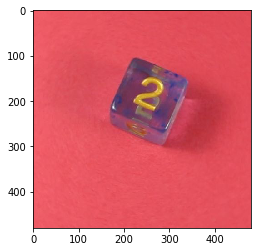

In [ ]:
# grab a random image from the list of filenames
randomFile = np.random.choice(data_train['fnames'], size=1)
# pull full path for local image directory
testFile = '/'.join([LOCAL_IMAGE_DIR, 'train', randomFile[0]])
# display image
image = mpimg.imread(testFile)
plt.imshow(image)

# Resize images
I ran this model from my macbook, which is not particularly computationally beefy. To accomodate the limited memory, I resized all of the kaggle images (408 x 408) to 64x64 pixels, and then stored the 64x64x3 image arrays in hdf5 files, along with a one-hot classification.

In [ ]:
size = 64, 64

for infile in glob.glob(LOCAL_IMAGE_DIR+"/train/*.jpg"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "PNG")
    
for infile in glob.glob(LOCAL_IMAGE_DIR+"/test/*.jpg"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile)
    im.thumbnail(size)
    im.save(file + ".thumbnail", "PNG")

### Generate h5 files for train/test sets

In [ ]:
def quick_one_hot(Y_orig, labels):
    '''
    Y_orig is array of shape (m_examples,)
    labels is unique array of values in Y_orig
        of shape (num_labels)
    Output: array of shape (m, num_labels)
        >>> labels 1-6 correspond to index 0-5 (0-index)
    Note: you can also use 
          keras.utils.to_categorical(y, num_classes)
    '''
    m = Y_orig.shape[0]
    num_labels = len(labels)
    # broadcasting
    Y_labs = np.ones((m, num_labels))*Y_orig[:,None]
    Y_inds = np.arange(1, num_labels+1)[None,:]*np.ones((m, num_labels))
    Y = (Y_inds == Y_labs)*1. # m_test x num_labels
    return Y

In [ ]:
def create_h5_output(data, subdir='train', outfile = 'train.txt'):
    '''
    input: data (np.recarray of image names, labels)
           subdir ('train', or 'test')
           outfile for hdf5 file ('/path/to/train.hdf5')
    '''
    labels = np.unique(data['Y'])
    numb_labels = len(labels)
    m = len(data['fnames'])
    
    # grab list of images
    fileList = np.array(['/'.join([LOCAL_IMAGE_DIR,
                                   subdir,
                                   data['fnames'][i]])
                         for i in range(m)])
    # initialize output
    X = np.zeros((m, 64, 64, 3))

    for i, file_ in enumerate(fileList):
        img = Image.open(file_.replace('.jpg', '.thumbnail'))
        X[i] = np.asarray(img)/255.
    # print results
    print('The data set has shape {0}'.format(X.shape))
    # check shape of one-hot
    Y = quick_one_hot(data['Y'], labels)
    print('The output is shape {0}'.format(Y.shape))
    
    # prepare hdf5 file
    hf = h5py.File(outfile, 'w')
    # add X, Y, use subdir to name
    hf.create_dataset('X_{}'.format(subdir),
                      data=X, compression='gzip')
    hf.create_dataset('Y_{}'.format(subdir),
                      data=Y, compression='gzip')
    # close file to write
    hf.close()
    print('Wrote to {}'.format(outfile))
    return

In [ ]:
# train data
create_h5_output(data_train, subdir='train',
                 outfile = LOCAL_IMAGE_DIR+'/d6_train.h5')

The data set has shape (4046, 64, 64, 3)
The output is shape (4046, 6)
Wrote to /Users/ebyler/research/ml/dice/d6_train.h5


In [ ]:
# test data
create_h5_output(data_test, subdir='test',
                 outfile = LOCAL_IMAGE_DIR+'/d6_test.h5')

The data set has shape (578, 64, 64, 3)
The output is shape (578, 6)
Wrote to /Users/ebyler/research/ml/dice/d6_test.h5


## Read in train/test data

In [ ]:
# training set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_train.h5', 'r') as f:
    X_train = np.array(f['X_train'][:])
    Y_train = np.array(f['Y_train'][:])

# test set
with h5py.File(LOCAL_IMAGE_DIR+'/d6_test.h5', 'r') as f:
    X_test = np.array(f['X_test'][:])
    Y_test = np.array(f['Y_test'][:])

# useful numbers
m_test, n_H, n_W, n_C = X_test.shape
m_train, n_y = Y_train.shape

print(f'Number of training examples: {m_train}')
print(f'Number of test examples: {m_test}')
print(f'Dimensions of images: {n_H} x {n_W} x {n_C}')
print(f'Number of output classes: {n_y}')

Number of training examples: 4046
Number of test examples: 578
Dimensions of images: 64 x 64 x 3
Number of output classes: 6


y = [1. 0. 0. 0. 0. 0.]


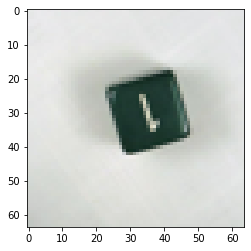

In [ ]:
# Example of resized image
index = np.random.choice(X_train.shape[0],1)[0]
plt.imshow(X_train[index])
print ("y = " + str(np.squeeze(Y_train[index])))

## Set up framework for NN

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


I'm using a simple convolutional neural network architecture, inspired by the LeNet-5 model, which was used to recognize handwritten digits. The model is structured as follows:
1. Convolution layer
  - ReLU activation
  - 8 filters, 4x4 kernel
2. Pooling layer
  - max pooling
3. Convolution layer
  - ReLU activation
  - 16 filters, 2x2 kernel
4. Pooling layer
  - max pooling
5. Fully connected layer
  - softmax with 6 outputs

In [ ]:
# fix model structure
batch_size=64
epochs=400
num_classes = n_y
nfilters = [8, 16]
kernel_sizes = [(4,4), (2,2)]

# relevant hyperparameters (default for Adam optimizer)
learning_rate=0.0001
decay=1e-6

In [ ]:
model = Sequential()

# CONV1 (ReLU) > POOL1
model.add(Conv2D(nfilters[0], kernel_sizes[0], # 8 filters, 4x4
                 strides=(1,1),
                 padding='same', 
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(8,8),
                       strides=(8,8),
                       padding='same'))
# CONV2 (ReLU) > POOL2
model.add(Conv2D(nfilters[1], kernel_sizes[1], # 16 filters, 2x2
                 strides=(1,1),
                 padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),
                       strides=(4,4),
                       padding='same'))

# Fully connected layer with softmax
model.add(Flatten())
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# We will use the Adam optimizer
opt = keras.optimizers.Adam(learning_rate=learning_rate, decay=decay)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Optimize

In [ ]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          shuffle=True)

Train on 4046 samples, validate on 578 samples
Epoch 1/400
4046/4046 [==============================] - 3s 723us/step - loss: 1.9006 - accuracy: 0.1389 - val_loss: 1.8341 - val_accuracy: 0.1592
Epoch 2/400
4046/4046 [==============================] - 2s 557us/step - loss: 1.8080 - accuracy: 0.1569 - val_loss: 1.7875 - val_accuracy: 0.1799
Epoch 3/400
4046/4046 [==============================] - 2s 555us/step - loss: 1.7746 - accuracy: 0.2467 - val_loss: 1.7636 - val_accuracy: 0.2785
Epoch 4/400
4046/4046 [==============================] - 2s 555us/step - loss: 1.7547 - accuracy: 0.2793 - val_loss: 1.7463 - val_accuracy: 0.2785
Epoch 5/400
4046/4046 [==============================] - 2s 558us/step - loss: 1.7371 - accuracy: 0.3070 - val_loss: 1.7279 - val_accuracy: 0.3426
Epoch 6/400
4046/4046 [==============================] - 2s 552us/step - loss: 1.7158 - accuracy: 0.3285 - val_loss: 1.7050 - val_accuracy: 0.3201
Epoch 7/400
4046/4046 [==============================] - 2s 551us/step 

4046/4046 [==============================] - 2s 573us/step - loss: 0.8509 - accuracy: 0.7313 - val_loss: 0.8515 - val_accuracy: 0.7318
Epoch 57/400
4046/4046 [==============================] - 2s 548us/step - loss: 0.8375 - accuracy: 0.7313 - val_loss: 0.8382 - val_accuracy: 0.7405
Epoch 58/400
4046/4046 [==============================] - 2s 572us/step - loss: 0.8244 - accuracy: 0.7410 - val_loss: 0.8257 - val_accuracy: 0.7491
Epoch 59/400
4046/4046 [==============================] - 2s 599us/step - loss: 0.8115 - accuracy: 0.7467 - val_loss: 0.8128 - val_accuracy: 0.7526
Epoch 60/400
4046/4046 [==============================] - 2s 535us/step - loss: 0.7990 - accuracy: 0.7548 - val_loss: 0.8009 - val_accuracy: 0.7578
Epoch 61/400
4046/4046 [==============================] - 2s 554us/step - loss: 0.7862 - accuracy: 0.7563 - val_loss: 0.7886 - val_accuracy: 0.7595
Epoch 62/400
4046/4046 [==============================] - 2s 564us/step - loss: 0.7743 - accuracy: 0.7647 - val_loss: 0.7779 

4046/4046 [==============================] - 2s 553us/step - loss: 0.4372 - accuracy: 0.8774 - val_loss: 0.4472 - val_accuracy: 0.8702
Epoch 112/400
4046/4046 [==============================] - 2s 534us/step - loss: 0.4331 - accuracy: 0.8796 - val_loss: 0.4432 - val_accuracy: 0.8702
Epoch 113/400
4046/4046 [==============================] - 2s 541us/step - loss: 0.4282 - accuracy: 0.8784 - val_loss: 0.4395 - val_accuracy: 0.8772
Epoch 114/400
4046/4046 [==============================] - 2s 546us/step - loss: 0.4242 - accuracy: 0.8811 - val_loss: 0.4353 - val_accuracy: 0.8772
Epoch 115/400
4046/4046 [==============================] - 2s 555us/step - loss: 0.4206 - accuracy: 0.8841 - val_loss: 0.4310 - val_accuracy: 0.8754
Epoch 116/400
4046/4046 [==============================] - 2s 545us/step - loss: 0.4165 - accuracy: 0.8851 - val_loss: 0.4274 - val_accuracy: 0.8789
Epoch 117/400
4046/4046 [==============================] - 2s 552us/step - loss: 0.4125 - accuracy: 0.8866 - val_loss: 0

4046/4046 [==============================] - 2s 545us/step - loss: 0.2643 - accuracy: 0.9325 - val_loss: 0.2747 - val_accuracy: 0.9360
Epoch 167/400
4046/4046 [==============================] - 2s 532us/step - loss: 0.2619 - accuracy: 0.9330 - val_loss: 0.2727 - val_accuracy: 0.9343
Epoch 168/400
4046/4046 [==============================] - 2s 532us/step - loss: 0.2595 - accuracy: 0.9345 - val_loss: 0.2704 - val_accuracy: 0.9325
Epoch 169/400
4046/4046 [==============================] - 2s 532us/step - loss: 0.2574 - accuracy: 0.9345 - val_loss: 0.2676 - val_accuracy: 0.9360
Epoch 170/400
4046/4046 [==============================] - 2s 531us/step - loss: 0.2562 - accuracy: 0.9348 - val_loss: 0.2653 - val_accuracy: 0.9377
Epoch 171/400
4046/4046 [==============================] - 2s 534us/step - loss: 0.2535 - accuracy: 0.9348 - val_loss: 0.2642 - val_accuracy: 0.9325
Epoch 172/400
4046/4046 [==============================] - 2s 531us/step - loss: 0.2507 - accuracy: 0.9357 - val_loss: 0

4046/4046 [==============================] - 2s 549us/step - loss: 0.1670 - accuracy: 0.9605 - val_loss: 0.1760 - val_accuracy: 0.9585
Epoch 222/400
4046/4046 [==============================] - 2s 540us/step - loss: 0.1653 - accuracy: 0.9614 - val_loss: 0.1743 - val_accuracy: 0.9602
Epoch 223/400
4046/4046 [==============================] - 2s 546us/step - loss: 0.1642 - accuracy: 0.9619 - val_loss: 0.1728 - val_accuracy: 0.9602
Epoch 224/400
4046/4046 [==============================] - 2s 544us/step - loss: 0.1630 - accuracy: 0.9624 - val_loss: 0.1713 - val_accuracy: 0.9602
Epoch 225/400
4046/4046 [==============================] - 2s 559us/step - loss: 0.1611 - accuracy: 0.9642 - val_loss: 0.1700 - val_accuracy: 0.9619
Epoch 226/400
4046/4046 [==============================] - 2s 548us/step - loss: 0.1602 - accuracy: 0.9642 - val_loss: 0.1689 - val_accuracy: 0.9602
Epoch 227/400
4046/4046 [==============================] - 2s 543us/step - loss: 0.1591 - accuracy: 0.9644 - val_loss: 0

4046/4046 [==============================] - 2s 530us/step - loss: 0.1068 - accuracy: 0.9775 - val_loss: 0.1137 - val_accuracy: 0.9758
Epoch 277/400
4046/4046 [==============================] - 2s 538us/step - loss: 0.1066 - accuracy: 0.9787 - val_loss: 0.1122 - val_accuracy: 0.9810
Epoch 278/400
4046/4046 [==============================] - 2s 536us/step - loss: 0.1050 - accuracy: 0.9792 - val_loss: 0.1117 - val_accuracy: 0.9792
Epoch 279/400
4046/4046 [==============================] - 2s 538us/step - loss: 0.1043 - accuracy: 0.9792 - val_loss: 0.1132 - val_accuracy: 0.9758
Epoch 280/400
4046/4046 [==============================] - 2s 533us/step - loss: 0.1032 - accuracy: 0.9785 - val_loss: 0.1101 - val_accuracy: 0.9758
Epoch 281/400
4046/4046 [==============================] - 2s 534us/step - loss: 0.1025 - accuracy: 0.9807 - val_loss: 0.1097 - val_accuracy: 0.9758
Epoch 282/400
4046/4046 [==============================] - 2s 536us/step - loss: 0.1022 - accuracy: 0.9812 - val_loss: 0

4046/4046 [==============================] - 2s 561us/step - loss: 0.0691 - accuracy: 0.9891 - val_loss: 0.0753 - val_accuracy: 0.9879
Epoch 332/400
4046/4046 [==============================] - 2s 560us/step - loss: 0.0686 - accuracy: 0.9886 - val_loss: 0.0750 - val_accuracy: 0.9896
Epoch 333/400
4046/4046 [==============================] - 2s 545us/step - loss: 0.0683 - accuracy: 0.9889 - val_loss: 0.0740 - val_accuracy: 0.9896
Epoch 334/400
4046/4046 [==============================] - 2s 558us/step - loss: 0.0674 - accuracy: 0.9899 - val_loss: 0.0736 - val_accuracy: 0.9862
Epoch 335/400
4046/4046 [==============================] - 2s 547us/step - loss: 0.0667 - accuracy: 0.9899 - val_loss: 0.0735 - val_accuracy: 0.9879
Epoch 336/400
4046/4046 [==============================] - 2s 564us/step - loss: 0.0665 - accuracy: 0.9901 - val_loss: 0.0724 - val_accuracy: 0.9896
Epoch 337/400
4046/4046 [==============================] - 2s 552us/step - loss: 0.0658 - accuracy: 0.9899 - val_loss: 0

4046/4046 [==============================] - 2s 535us/step - loss: 0.0444 - accuracy: 0.9946 - val_loss: 0.0514 - val_accuracy: 0.9913
Epoch 387/400
4046/4046 [==============================] - 2s 557us/step - loss: 0.0441 - accuracy: 0.9946 - val_loss: 0.0512 - val_accuracy: 0.9913
Epoch 388/400
4046/4046 [==============================] - 2s 555us/step - loss: 0.0438 - accuracy: 0.9946 - val_loss: 0.0506 - val_accuracy: 0.9931
Epoch 389/400
4046/4046 [==============================] - 2s 570us/step - loss: 0.0433 - accuracy: 0.9951 - val_loss: 0.0509 - val_accuracy: 0.9931
Epoch 390/400
4046/4046 [==============================] - 2s 547us/step - loss: 0.0430 - accuracy: 0.9948 - val_loss: 0.0504 - val_accuracy: 0.9913
Epoch 391/400
4046/4046 [==============================] - 2s 535us/step - loss: 0.0426 - accuracy: 0.9956 - val_loss: 0.0500 - val_accuracy: 0.9913
Epoch 392/400
4046/4046 [==============================] - 2s 533us/step - loss: 0.0423 - accuracy: 0.9948 - val_loss: 0

In [ ]:
# Score trained model.
scores = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

578/578 [==============================] - 0s 352us/step
Test loss: 0.04640954784778266
Test accuracy: 0.9948096871376038


### Save trained model

In [ ]:
save_dir = LOCAL_IMAGE_DIR+'/models/'
model_name = 'keras_2CONV_trained_model.h5'

In [ ]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/ebyler/research/ml/dice/models/keras_2CONV_trained_model.h5 


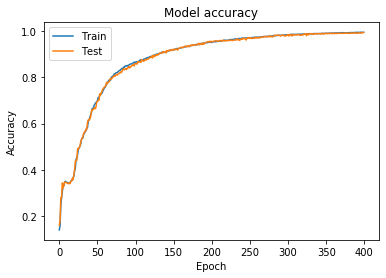

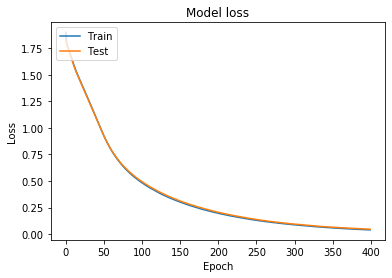

In [ ]:
# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Load previously saved model

In [ ]:
from keras.models import load_model
model_path = os.path.join(save_dir, model_name)
model = load_model(model_path)

# Test trained model

Y(true) = [0. 0. 1. 0. 0. 0.]
Y(pred) = [0. 0. 1. 0. 0. 0.]


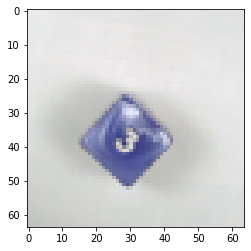

In [ ]:
index = np.random.choice(X_test.shape[0],1)[0]
plt.imshow(X_test[index])
print ("Y(true) = " + str(np.squeeze(Y_train[index])))

Y_pred = model.predict_classes(X_test[index:index+1])
Y_vec = keras.utils.to_categorical(Y_pred, num_classes=num_classes)
print ("Y(pred) = " + str(Y_vec[0]))